Multipleclass SVM Model prediction for SMASS survery, F1 score: ~ 0.98

In [1]:
# Import standard libraries
import os

# Import installed libraries
import numpy as np
import pandas as pd
import sklearn

from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import GridSearchCV

In [4]:
# Load the level 2 asteroid data
core_path = "../asteroid_taxonomy"
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

In [5]:
# Extract and concatenate Reflectance_norm550nm and Wavelength_in_microm for each sample
asteroids_X = np.array([
    np.concatenate((
        row["SpectrumDF"]["Reflectance_norm550nm"].values,
        row["SpectrumDF"]["Wavelength_in_microm"].values
    )) for _, row in asteroids_df.iterrows()
])


asteroids_y = np.array(asteroids_df["Main_Group"].to_list())

In [6]:
print(f"Length of asteroids_X: {len(asteroids_X)}")
print(f"Length of asteroids_y: {len(asteroids_y)}")

Length of asteroids_X: 1341
Length of asteroids_y: 1341


In [7]:
asteroids_X

array([[0.9281, 0.9388, 0.9488, ..., 0.9   , 0.91  , 0.92  ],
       [0.9758, 0.9788, 0.9816, ..., 0.9   , 0.91  , 0.92  ],
       [0.8692, 0.8824, 0.8962, ..., 0.9   , 0.91  , 0.92  ],
       ...,
       [0.8152, 0.8323, 0.8496, ..., 0.9   , 0.91  , 0.92  ],
       [0.8293, 0.8467, 0.864 , ..., 0.9   , 0.91  , 0.92  ],
       [0.8412, 0.8571, 0.8728, ..., 0.9   , 0.91  , 0.92  ]])

In [8]:
label = np.unique(asteroids_y)
label

array(['C', 'Other', 'S', 'X'], dtype='<U5')

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Create a simple, single train/test split
for train_index, test_index in sss.split(asteroids_X, asteroids_y):
    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_y[train_index], asteroids_y[test_index]

# Compute class weightings
weight_dict = {}
for ast_type in np.unique(y_train):
    weight_dict[ast_type] = int(1.0 / (len(y_train[y_train == ast_type]) / len(y_train)))

print("Class weights:", weight_dict)

Class weights: {np.str_('C'): 3, np.str_('Other'): 8, np.str_('S'): 2, np.str_('X'): 5}


In [11]:
from sklearn.metrics import make_scorer, f1_score

param_grid = [
  {'C': np.logspace(0, 2.5, 25), 'kernel': ['rbf']},
 ]

# Set the SVM classifier
svc = svm.SVC(class_weight=weight_dict)

# the scaler StandardScaler expected <= dim. 2.
scaler = preprocessing.StandardScaler().fit(X_train)

# Transform now the training data
X_train_scaled = scaler.transform(X_train)

# Set the GridSearch. Use the f1 "weighted" score in a maker_scorer function.
# pos_label: None for mutliple class
wclf = GridSearchCV(
    svc, param_grid, scoring=make_scorer(
        f1_score, average="weighted", pos_label=None),
        verbose=3, cv=5)

# perform the training!
wclf.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END .................C=1.0, kernel=rbf;, score=0.932 total time=   0.0s
[CV 2/5] END .................C=1.0, kernel=rbf;, score=0.932 total time=   0.0s
[CV 3/5] END .................C=1.0, kernel=rbf;, score=0.981 total time=   0.0s
[CV 4/5] END .................C=1.0, kernel=rbf;, score=0.941 total time=   0.0s
[CV 5/5] END .................C=1.0, kernel=rbf;, score=0.936 total time=   0.0s
[CV 1/5] END ..C=1.2710617996147449, kernel=rbf;, score=0.940 total time=   0.0s
[CV 2/5] END ..C=1.2710617996147449, kernel=rbf;, score=0.932 total time=   0.0s
[CV 3/5] END ..C=1.2710617996147449, kernel=rbf;, score=0.977 total time=   0.0s
[CV 4/5] END ..C=1.2710617996147449, kernel=rbf;, score=0.946 total time=   0.0s
[CV 5/5] END ..C=1.2710617996147449, kernel=rbf;, score=0.936 total time=   0.0s
[CV 1/5] END ..C=1.6155980984398741, kernel=rbf;, score=0.940 total time=   0.0s
[CV 2/5] END ..C=1.6155980984398741, kernel=rbf

GridSearchCV(cv=5,
             estimator=SVC(class_weight={np.str_('C'): 3, np.str_('Other'): 8,
                                         np.str_('S'): 2, np.str_('X'): 5}),
             param_grid=[{'C': array([  1.        ,   1.2710618 ,   1.6155981 ,   2.05352503,
         2.61015722,   3.31767113,   4.21696503,   5.36002317,
         6.81292069,   8.65964323,  11.00694171,  13.99050314,
        17.7827941 ,  22.60303027,  28.72984833,  36.51741273,
        46.41588834,  58.99746256,  74.98942093,  95.31618832,
       121.15276586, 153.99265261, 195.73417815, 248.79023672,
       316.22776602]),
                          'kernel': ['rbf']}],
             scoring=make_scorer(f1_score, response_method='predict', average=weighted, pos_label=None),
             verbose=3)

In [12]:
final_clf = wclf.best_estimator_

print(f"Kernel with best result: {final_clf}")

Kernel with best result: SVC(C=np.float64(4.216965034285822),
    class_weight={np.str_('C'): 3, np.str_('Other'): 8, np.str_('S'): 2,
                  np.str_('X'): 5})


In [13]:
final_clf.get_params()

{'C': np.float64(4.216965034285822),
 'break_ties': False,
 'cache_size': 200,
 'class_weight': {np.str_('C'): 3,
  np.str_('Other'): 8,
  np.str_('S'): 2,
  np.str_('X'): 5},
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [14]:
X_test_scaled = scaler.transform(X_test)
y_test_pred = final_clf.predict(X_test_scaled)

In [15]:
# metrics and confusion matrix
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_test_pred, labels=["C", "S", "X", "Other"])

print(conf_mat)

[[ 80   0   0   0]
 [  0 105   0   5]
 [  1   0  47   0]
 [  0   0   0  31]]


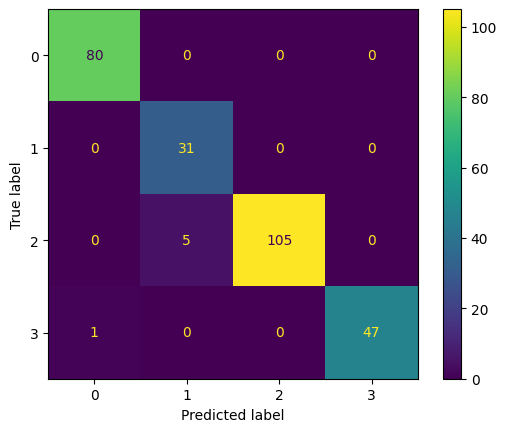

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# gets the info of final_clf form y_test_pred...
cm = confusion_matrix(y_test, y_test_pred)

# Create a ConfusionMatrixDisplay instance
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
disp.plot(values_format='d')
plt.show()

In [17]:
f1_score = round(sklearn.metrics.f1_score(y_test, y_test_pred, average="weighted"), 3)
print(f"F1 score: {f1_score * 100} %")

F1 score: 97.8 %
